# Init

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# import array
import glob

# Compute Camera Calibration

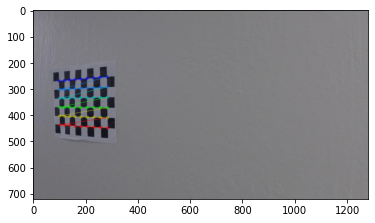

In [2]:
# prepare object points
# number of inside corners in x and y
ny = 6 
nx = 9

# Make a list of calibration images (calibration1..20)
images_cal = glob.glob('camera_cal/calibration*.jpg', recursive=False)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# create objp
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# get chessboard corners for all calibration images
for fname in images_cal:
    img_cal = plt.imread(fname)

    # Convert to grayscale
    gray_cal = cv2.cvtColor(img_cal, cv2.COLOR_RGB2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_cal, (nx, ny), None)

    # If corners found, draw corners
    if ret == True:
        objpoints.append(objp)
#         corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)
    
        # draw & display corners
        cv2.drawChessboardCorners(img_cal, (nx, ny), corners, ret)
        plt.imshow(img_cal)

In [3]:
# calibrate camera
ret, mtx, dist, rvecs, tvecs  = cv2.calibrateCamera(objpoints, imgpoints, img_cal.shape[1:], None,None)

# # undistort test image
# img_undist = cv2.undistort(img_cal, mtx, dist, None, mtx)
# plt.imshow(img_undist)

# Apply distortion correction

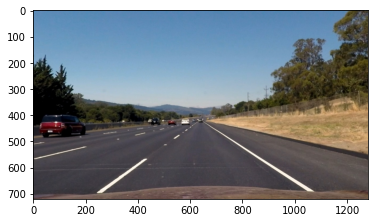

In [4]:
# load input image
img_input = plt.imread('test_images/straight_lines2.jpg')

# undistort camera images
img_undist = cv2.undistort(img_input, mtx, dist, None, mtx)
plt.imshow(img_undist)

# Generate thesholded binary image (color transform, gradients etc...)

In [5]:
# define functions

def extract_single_color(img):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    return s_channel

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = extract_single_color(image)
    if orient == 'x':
        sobel_orient = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel_orient = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel_orient)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)        
    grad_binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 255 #imshow accepts 1 not!
    return grad_binary

def abs_magn_thresh(image, magn_sobel_kernel=3, thresh_2=(0, 255)):
    # Calculate gradient magnitude
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = extract_single_color(image)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=magn_sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=magn_sobel_kernel)
#     magn = np.sqrt(sobel_x * sobel_x + sobel_y * sobel_y)
    magn = np.sqrt(np.power(sobel_x,2) + np.power(sobel_y,2))
    scaled_magn = np.uint8(255*magn/np.max(magn))
    # Apply threshold
    magn_binary = np.zeros_like(scaled_magn)       
    magn_binary[(scaled_magn > (thresh_2[0])) & (scaled_magn < thresh_2[1])] = 255
    return magn_binary

def abs_dir_threshold(image, dir_sobel_kernel=3, dir_thresh=(-np.pi/2, np.pi/2)):
    # Calculate gradient direction
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = extract_single_color(image)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=dir_sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=dir_sobel_kernel)
    abs_grad_x = np.absolute(sobel_x)
    abs_grad_y = np.absolute(sobel_y)
    direction_grad = np.arctan2(abs_grad_y, abs_grad_x)
    # Apply threshold
    dir_binary = np.zeros_like(direction_grad)
    dir_binary[(direction_grad > dir_thresh[0]) & (direction_grad < dir_thresh[1])] = 1
    return dir_binary

def abs_average(binary_image, filter_size=3):
    output_image = cv2.blur(binary_image, (filter_size, filter_size))       
#         output_image = cv2.medianBlur(binary_image, filter_size)
    return output_image

def abs_threshold(image, threshold):
    binary_image = np.zeros_like(image)
    binary_image[image > threshold/255] = 255
    return binary_image

True

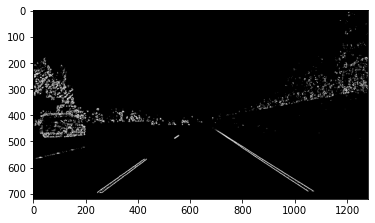

In [6]:
# filter parameters
_sobelx_low = 16
_sobelx_high = 255
_sobelx_filter = 3

_sobely_low = 36
_sobely_high = 255
_sobely_filter = 3

_magn_low = 15
_magn_high = 255
_magn_filter = 3

_direction_low = 229
_direction_high = 287
_direction_filter = 15
_direction_avg_filter = 11
_direction_thresh = 143

# use functions to generate binary image
_sobelx_binary = abs_sobel_thresh(img_undist, 'x', _sobelx_filter, (_sobelx_low, _sobelx_high))
_sobely_binary = abs_sobel_thresh(img_undist, 'y', _sobely_filter, (_sobely_low, _sobely_high))
_mag_binary = abs_magn_thresh(img_undist, _magn_filter, (_magn_low, _magn_high))
_dir_binary = abs_dir_threshold(img_undist, _direction_filter, (_direction_low, _direction_high))
_avg_img = abs_average(_dir_binary, _direction_avg_filter)
_thres_img = abs_threshold(_avg_img, _direction_thresh)
combined_binary = np.zeros_like(_sobelx_binary)
combined_binary[((_sobelx_binary == 255) & (_sobely_binary == 255)) | ((_mag_binary == 255) & (_thres_img == 255))] = 255

plt.imshow(combined_binary, cmap='gray')
cv2.imwrite("output_images/combined_binary.jpg", combined_binary)

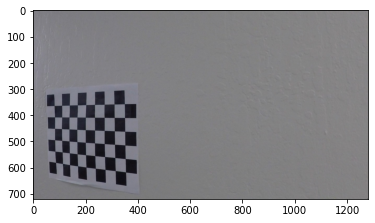

In [7]:
image_cal = plt.imread(images_cal[10])
plt.imshow(image_cal)

# Apply a perspective transform to rectify binary image (bird-eye view)

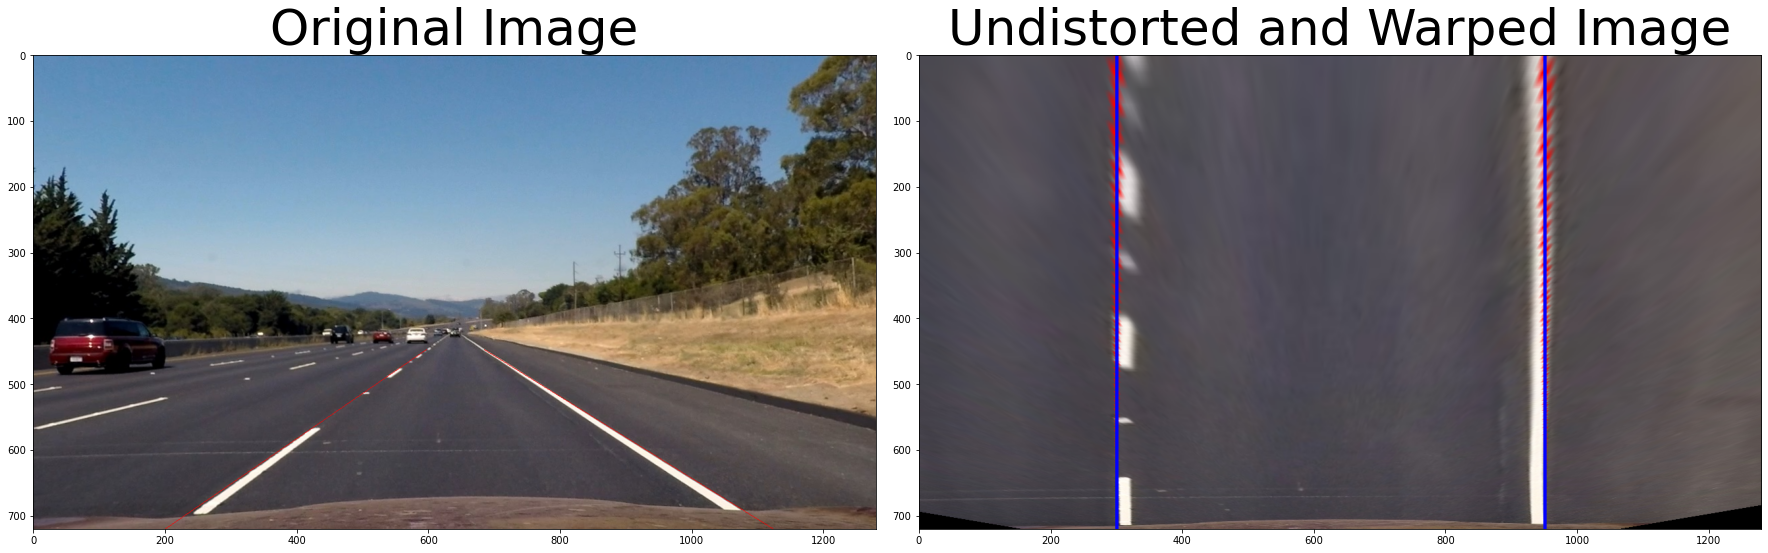

In [8]:
# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
#     # Pass in your image into this function
#     # Write code to do the following steps
#     # 1) Undistort using mtx and dist
#     dst_img = cv2.undistort(img, mtx, dist, None, mtx)
#     # 2) Convert to grayscale
#     dst_gray = cv2.cvtColor(dst_img, cv2.COLOR_RGB2GRAY)
#     # 3) Find the chessboard corners
#     ret, corners = cv2.findChessboardCorners(dst_gray, (nx,ny), None)
#     # 4) If corners found: 

# #     if ret == True:
#     # a) draw corners
#     dst_corners = cv2.drawChessboardCorners(dst_img, (nx, ny), corners, ret)
    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
         #Note: you could pick any four of the detected corners 
         # as long as those four corners define a rectangle
         #One especially smart way to do this would be to use four well-chosen
         # corners that were automatically detected during the undistortion steps
         #We recommend using the automatic detection of corners in your code
#     src = np.float32([[corners[0][0][0],corners[0][0][1]],[corners[nx-1][0][0],corners[nx-1][0][1]],[corners[nx*(ny-1)][0][0],corners[nx*(ny-1)][0][1]],[corners[nx*ny-1][0][0],corners[nx*ny-1][0][1]]])
    src = np.float32([[200,img.shape[0]],[597,447],[685,447],[1124,img.shape[0]]])
#     src = np.float32([[177,img.shape[0]],[595,447],[685,447],[1124,img.shape[0]]])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
#     dx = dst_img.shape[1]/(nx+1)*nx
#     dy = dst_img.shape[0]/(nx+1)*nx
#     x = dst_img.shape[1]/(nx+1)/2
#     y = dst_img.shape[0]/(nx+1)/2
#     dst = np.float32([[x,y],[x+dx,y],[x,y+dy],[x+dx,y+dy]])
#     dst = np.float32([[0,img.shape[0]],[0,0],[img.shape[1],0],[img.shape[1],img.shape[0]]])
    dst = np.float32([[300,img.shape[0]],[300,0],[950,0],[950,img.shape[0]]])
#     dst = np.float32([[177,img.shape[0]],[177,0],[1124,0],[1124,img.shape[0]]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M =  cv2.getPerspectiveTransform(src, dst)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    #delete the next two lines
    # M = None
    # warped = np.copy(transformed_dst) 
    draw_line(warped, 300,img_undist.shape[0], 300,0, [0, 0, 255])
    draw_line(warped, 950,img_undist.shape[0], 950,0, [0, 0, 255])
    
    return warped, M

def draw_line(img, x1, y1, x2, y2, color=[255, 0, 0], thickness=3):
    return cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# draw lines for correction
draw_line(img_undist, 200,img_undist.shape[0], 597,447,thickness=1)
draw_line(img_undist, 685,447, 1124,img_undist.shape[0],thickness=1)

top_down, perspective_M = corners_unwarp(img_undist, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_undist, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Detect lane pixels and fit to find the lane boundary.

# Determine the curvature of the lane and vehicle position with respect to center.

# Warp the detected lane boundaries back onto the original image.

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position